Process images

In [72]:
import os
from os.path import exists
import pandas as pd
import numpy as np
import cv2

# Import function to extract features
from extract_features import  process_images

#-------------------
# Main script
#-------------------

# Defining paths to metadata, images and their masks
file_data = '..' + os.sep + 'data' + os.sep + 'metadata.csv'
path_image = '..' + os.sep + 'data' + os.sep + 'images' + os.sep + 'images_train'
path_mask = '..' + os.sep + 'data' + os.sep + 'images' + os.sep + 'masks_train'    

# Defining the path to store the features
file_features = 'features/features_original.csv'
feature_names = ['asymmetry', 'colours', 'dots and globules', 'compactness']

#Processing images and saving annotations to csv
df_features=process_images(file_data, path_image, path_mask,feature_names)
df_features.to_csv(file_features, index=False)

Train classifier

In [73]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report
import pickle
import pandas as pd
import numpy as np

# Read metadata
metadata_df = pd.read_csv(file_data)
df_features = pd.read_csv(file_features)
feature_names = ['asymmetry', 'colours', 'dots and globules', 'compactness']
# Merging created annotations with patient details
combined_df = df_features.merge(metadata_df[['img_id', 'diagnostic', 'patient_id']], left_on='image_id', right_on='img_id', how='left')
if combined_df.isnull().values.any():
    raise ValueError("NaN values detected after merge! Check the data integrity.")

# Preparing the dataset
#defining canserous diagnosis
combined_df['target'] = np.logical_or(combined_df['diagnostic'].values == 'BCC', combined_df['diagnostic'].values == 'MEL', combined_df['diagnostic'].values == 'SCC') 
patient_id = combined_df['patient_id'].values
y = combined_df['target'].values
X = combined_df[feature_names].values


# Preparing cross-validation
num_folds = 5
group_kfold = GroupKFold(n_splits=num_folds)

# Initialize classifiers with appropriate names
classifiers = [
    KNeighborsClassifier(1),
    KNeighborsClassifier(5),
    RandomForestClassifier(n_estimators=100, random_state=42),
    GradientBoostingClassifier(n_estimators=100, random_state=42),
    AdaBoostClassifier(n_estimators=100, random_state=42),
    DecisionTreeClassifier(random_state=42),
    make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, class_weight='balanced')),
    make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3)),
    GaussianNB()
]

classifier_names = [
    "KNeighbors (n=1)", "KNeighbors (n=5)", 
    "RandomForest", "GradientBoosting", 
    "AdaBoost", "DecisionTree", 
    "LogisticRegression (Std)", "LogisticRegression (Std, Balanced)",
    "SGDClassifier (Std)", "GaussianNB"
]

# Initializing accuracy storage
acc_val = np.empty((num_folds, len(classifiers)))

# Preparing the directory for saving classifier files
classifiers_save_path = 'Trained_classifiers'  
if not os.path.exists(classifiers_save_path):
    os.makedirs(classifiers_save_path)

# Performing cross-validation
for j, clf in enumerate(classifiers):
    fold_accuracies = []
    for i, (train_index, val_index) in enumerate(group_kfold.split(X, y, patient_id)):
        x_train, y_train = X[train_index], y[train_index]
        x_val, y_val = X[val_index], y[val_index]
        
        # Fitting and predicting
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_val)
        acc = accuracy_score(y_val, y_pred)
        fold_accuracies.append(acc)
        
        # Saving the classifier after training on this fold
        fold_filename = f'{classifier_names[j]}_fold_{i}.sav'
        fold_path = os.path.join(classifiers_save_path, fold_filename)
        pickle.dump(clf, open(fold_path, 'wb'))
    
    acc_val[:, j] = fold_accuracies

# Calculating average accuracy for each classifier
average_acc = np.mean(acc_val, axis=0)
for idx, acc in enumerate(average_acc):
    print(f'Classifier {classifier_names[idx]}: average accuracy={acc:.3f}')

# Saving and evaluating each classifier on the full dataset
eval_results = {}
for idx, clf in enumerate(classifiers):
    
    classifier_filename = f'{classifier_names[idx]}.sav'
    full_classifier_path = os.path.join(classifiers_save_path, classifier_filename)
    
    # Saving classifier
    with open(full_classifier_path, 'wb') as f:
        pickle.dump(clf, f)
    
    # Loading classifier
    with open(full_classifier_path, 'rb') as f:
        loaded_clf = pickle.load(f)
    
    # Predicting on the full dataset and calculating evaluation metrics
    y_pred = loaded_clf.predict(X)
    acc = accuracy_score(y, y_pred)
    clf_report = classification_report(y, y_pred)
    
    eval_results[classifier_names[idx]] = {'accuracy': acc, 'report': clf_report}


# Displaying evaluation results
for clf_name, results in eval_results.items():
    print(f"Results for {clf_name}:")
    print(f"Accuracy: {results['accuracy']}")
    #print(f"Classification Report:\n{results['report']}\n")

c:\Users\tettret\Downloads\Anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\tettret\Downloads\Anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\tettret\Downloads\Anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\tettret\Downloads\Anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Classifier KNeighbors (n=1): average accuracy=0.524
Classifier KNeighbors (n=5): average accuracy=0.523
Classifier RandomForest: average accuracy=0.526
Classifier GradientBoosting: average accuracy=0.589
Classifier AdaBoost: average accuracy=0.591
Classifier DecisionTree: average accuracy=0.528
Classifier LogisticRegression (Std): average accuracy=0.587
Classifier LogisticRegression (Std, Balanced): average accuracy=0.495
Classifier SGDClassifier (Std): average accuracy=0.562
Classifier GaussianNB: average accuracy=0.567
Results for KNeighbors (n=1):
Accuracy: 0.8190572731880386
Results for KNeighbors (n=5):
Accuracy: 0.670045615813482
Results for RandomForest:
Accuracy: 0.8246325392802838
Results for GradientBoosting:
Accuracy: 0.6614292954891029
Results for AdaBoost:
Accuracy: 0.6249366447034972
Results for DecisionTree:
Accuracy: 0.8220983274201723
Results for LogisticRegression (Std):
Accuracy: 0.5879371515458692
Results for LogisticRegression (Std, Balanced):
Accuracy: 0.494678155

Evaluate classifier

In [68]:
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix
import glob

#Defining path to metadata and testing set
file_data = '..' + os.sep + 'data' + os.sep + 'metadata.csv'
path_image = '..' + os.sep + 'data' + os.sep + 'images' + os.sep + 'images_evaluate'
path_mask = '..' + os.sep + 'data' + os.sep + 'images' + os.sep + 'masks_evaluate'    

#Processing images
feature_names = ['asymmetry', 'colours', 'dots and globules', 'compactness']
features_df = process_images(file_data, path_image, path_mask,feature_names)

# Merging features with metadata 
combined_df = features_df.merge(metadata_df[['img_id', 'diagnostic', 'patient_id']], left_on='image_id', right_on='img_id', how='left')

# Preparing the dataset
cancerous_conditions = ['BCC', 'MEL', 'SCC']
combined_df['target'] = combined_df['target'] = np.logical_or(combined_df['diagnostic'].values == 'BCC', combined_df['diagnostic'].values == 'MEL', combined_df['diagnostic'].values == 'SCC')
patient_id = combined_df['patient_id'].values
y = combined_df['target'].values
X = combined_df[feature_names].values

# Function to load a classifier and evaluate it
def load_and_evaluate(model_filename, X, y):
    try:
        with open(model_filename, 'rb') as model_file:
            classifier = pickle.load(model_file)
        print(f"Loaded classifier from {model_filename}")
    except Exception as e:
        print(f"An error occurred while loading the model from {model_filename}: {e}")
        return None, None

    # Predicting the labels and calculating accuracy and confusion matrix
    pred_labels = classifier.predict(X)
    accuracy = accuracy_score(y, pred_labels)
    cm = confusion_matrix(y, pred_labels)
    
    return accuracy, cm

# List of classifier filenames
classifier_dir = 'Trained_classifiers'
classifier_filenames = glob.glob(os.path.join(classifier_dir, '*.sav'))
# Evaluate all classifiers
for model_filename in classifier_filenames:
    accuracy, cm = load_and_evaluate(model_filename, X, y)
    model_name = os.path.basename(model_filename)
    print(f"Results for {model_name}:")
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", cm)


Loaded classifier from Trained_classifiers\AdaBoost.sav
Results for AdaBoost.sav:
Accuracy: 0.5590551181102362
Confusion Matrix:
 [[61 16]
 [40 10]]
Loaded classifier from Trained_classifiers\AdaBoost_fold_0.sav
Results for AdaBoost_fold_0.sav:
Accuracy: 0.5748031496062992
Confusion Matrix:
 [[65 12]
 [42  8]]
Loaded classifier from Trained_classifiers\AdaBoost_fold_1.sav
Results for AdaBoost_fold_1.sav:
Accuracy: 0.5590551181102362
Confusion Matrix:
 [[62 15]
 [41  9]]
Loaded classifier from Trained_classifiers\AdaBoost_fold_2.sav
Results for AdaBoost_fold_2.sav:
Accuracy: 0.6299212598425197
Confusion Matrix:
 [[65 12]
 [35 15]]
Loaded classifier from Trained_classifiers\AdaBoost_fold_3.sav
Results for AdaBoost_fold_3.sav:
Accuracy: 0.5984251968503937
Confusion Matrix:
 [[67 10]
 [41  9]]
Loaded classifier from Trained_classifiers\AdaBoost_fold_4.sav
Results for AdaBoost_fold_4.sav:
Accuracy: 0.5590551181102362
Confusion Matrix:
 [[61 16]
 [40 10]]
Loaded classifier from Trained_class

Predict labels and their probabilities

In [70]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from extract_features import  process_images

data_dir = os.path.join('..', 'data')
features_path = os.path.join(data_dir, 'metadata.csv')
path_image = os.path.join(data_dir, 'images', 'images_evaluate')
path_mask = os.path.join(data_dir, 'images', 'masks_evaluate')

#Define features to use in classification
feature_names = ['asymmetry', 'colours', 'dots and globules', 'compactness']
features_df = process_images(features_path, path_image, path_mask, feature_names)
# Load metadata
metadata_df = pd.read_csv(features_path)
combined_df = features_df.merge(metadata_df[['img_id', 'diagnostic', 'patient_id']], left_on='image_id', right_on='img_id', how='left')

# Define the target variable 'y' where '1' represents cancerous conditions and '0' represents non-cancerous conditions
cancerous_conditions = ['BCC', 'MEL', 'SCC']
combined_df['target'] = np.logical_or(combined_df['diagnostic'].values == 'BCC', combined_df['diagnostic'].values == 'MEL', combined_df['diagnostic'].values == 'SCC')
combined_df['target'] = combined_df['target'].astype(int)

# Load model and predict probabilities
def predict_probabilities(model_filename, X):
    try:
        with open(model_filename, 'rb') as model_file:
            classifier = pickle.load(model_file)
        print(f"Loaded classifier from {model_filename}")
        probabilities = classifier.predict_proba(X)
        return probabilities
    except Exception as e:
        print(f"An error occurred while loading the model: {e}")
        return None

#Define pass to the model 
model_filename = r"Queen_Snakes_classifier.sav"


# Create a list to save probabilities with patient id and labels
results = []

probabilities = predict_probabilities(model_filename, features_df[feature_names].values)
if probabilities is not None:
    # Iterate over each prediction and corresponding image ID
    for idx, prob in enumerate(probabilities):
        results.append({
            'Patient ID': combined_df.iloc[idx]['patient_id'],
            'Image ID': features_df.iloc[idx]['image_id'],
            'Probability Non-cancerous': prob[0],  # 0 is non-cancerous
            'Probability Cancerous': prob[1],     # 1 is cancerous
            'Actual Label': combined_df.iloc[idx]['target']  # Ensure target column exists
        })

# Create a DataFrame from results
results_df = pd.DataFrame(results)

# Define the Excel writer and the path for the Excel file
excel_path = 'predictions_new.xlsx'


# Write DataFrame to an Excel file
results_df.to_excel(excel_path, index=False)


print(f"Predictions have been saved to {excel_path}")


Loaded classifier from Queen_Snakes_classifier.sav
Predictions have been saved to predictions_new.xlsx


Confusion matrix , accuracy , precision, recall and F1 score for the selected algorithm

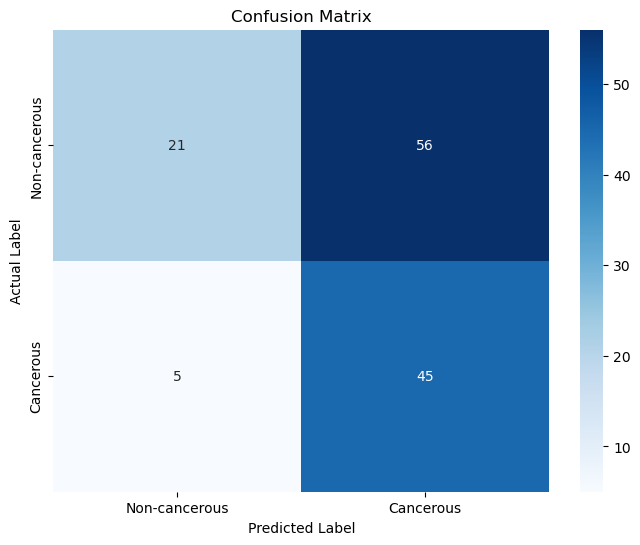

Accuracy: 0.52
Precision: 0.45
Recall: 0.90
F1 Score: 0.60


In [71]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

# Calculating the confusion matrix
y_true = results_df['Actual Label']
y_pred = results_df['Probability Cancerous'] > 0.5  # Threshold of 0.5
conf_mat = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-cancerous', 'Cancerous'], yticklabels=['Non-cancerous', 'Cancerous'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


# Computing metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)


# Displaying the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")